In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import pandas as pd 
from IPython.display import display
import textwrap
import json 
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models import LdaModel
import matplotlib.pyplot as plt

## Import speech dataset and preprocessed data for lda

In [43]:
filename = "data/csv/speech_output.csv"

df = pd.read_csv(filename)
df["year"] = df.apply(lambda s: int(s["date"][:4]), axis=1)
df["uq_agenda"] = df["agenda"]+df["date"]

/var/folders/6q/pqc7tgjx0_nfs5rp04gzmt640000gn/T/ipykernel_18284/488462102.py:3: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename)


In [44]:
# import preprocessed data: tokenization, lemmatization, stopword removal
preprocessed_data = json.load(open("data/lda/preprocessed_texts.json"))

# only use speeches where speaker is associated with a party
df_party_members = df[~(df["party"] == "-")]

# extract speeches that need to be translated
df_untranslated = df_party_members[df_party_members["translatedText"].isna()]

# for now: only use speeches which were given in english or machine translation availible
df_party_members = df_party_members[df_party_members["translatedText"].notna()]

# only keep speeches with at least 50 characters: important for coherence with preprocessed data
df_party_members = df_party_members[df_party_members["translatedText"].map(len) > 50]
len(preprocessed_data) == len(df_party_members)

df_party_members = df_party_members.reset_index(drop=True)

### We still need to translate speeches post 2019: how many? 

In [45]:
df_untranslated.head()

# compute number of speeches to be translated
num_speeches = df_untranslated.shape[0]
print(f"Number of speeches to be translated: {num_speeches}")

# compute number of speeches already translated
num_speeches_translated = df_party_members.shape[0]
print(f"Number of speeches already translated: {num_speeches_translated}")

# compute number of characters in untranslated speeches
total_chars = df_untranslated["text"].apply(len).sum()
print(f"Total characters to be translated: {total_chars}")

total_chars_translated = df_party_members["text"].apply(len).sum()
print(f"Total characters already translated: {total_chars_translated}")

Number of speeches to be translated: 52319
Number of speeches already translated: 453412
Total characters to be translated: 71931250
Total characters already translated: 508349742


## LDA: Define 80 (for now) topics and assign their probabilities to each speech

In [47]:
print("creating dictionary")
dictionary = corpora.Dictionary(preprocessed_data)
print("filtering dictionary")
dictionary.filter_extremes(
    no_below=10,     # Keep tokens appearing in at least 10 docs
    no_above=0.4,    # Remove tokens appearing in more than 40% of docs
    keep_n=100000    # Keep only the top 100k words by frequency
)
corpus = [dictionary.doc2bow(l) for l in tqdm(preprocessed_data, "Preparing corpus")]

creating dictionary
filtering dictionary


Preparing corpus: 100%|██████████| 453412/453412 [01:26<00:00, 5220.40it/s] 


In [48]:
def print_topics(model, n_topics, k_words=5):
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx + 1}: {label}")

In [49]:
def assign_topics(lda_model, corpus):
    # choose the LDA model to use (change if you want a different one)
    topics = []
    for bow in tqdm(corpus, desc="Assigning most probable topic to each doc"):
        docs_topics = lda_model.get_document_topics(bow, minimum_probability=0)
        topics.append(docs_topics)
    return topics

## Assign topics to speeches using pre-trained model

In [ ]:
n_topics = 80
model = LdaModel.load(f"data/lda/{n_topics}_topics/model.model")

corpus_topics = assign_topics(model, corpus)

Assigning most probable topic to each doc: 100%|██████████| 453412/453412 [02:38<00:00, 2862.67it/s]


In [51]:
# print list of topics
print_topics(model, n_topics)

Topic 1: kosovo, america, serbia, american, latin
Topic 2: waste, export, arm, material, weapon
Topic 3: ro, candidate, member, appointment, appoint
Topic 4: money, eu, spend, taxpayer, use
Topic 5: discrimination, roma, anti, racism, community
Topic 6: da, scandal, stem, indonesia, false
Topic 7: food, ban, commission, modify, use
Topic 8: russia, political, country, election, ukraine
Topic 9: language, minority, religious, christian, ethnic
Topic 10: euro, economic, country, crisis, greece
Topic 11: citizen, institution, initiative, transparency, union
Topic 12: population, city, people, urban, live
Topic 13: committee, affair, petition, parliament, work
Topic 14: woman, man, equality, gender, equal
Topic 15: french, france, lesson, learn, india
Topic 16: agreement, eu, union, trade, cooperation
Topic 17: member, state, convention, union, parliament
Topic 18: investment, project, fund, development, research
Topic 19: regulation, directive, proposal, commission, legal
Topic 20: mr, li

In [52]:
# corpus topics is a list of lists of (topic_id, probability) tuples for each document in the corpus
# turn this list into dataframe of size (num_docs, num_topics) with probabilities
num_docs = len(corpus_topics)
num_topics = n_topics
topic_prob_matrix = np.zeros((num_docs, num_topics))
for doc_idx, doc_topics in enumerate(corpus_topics):
    for topic_id, prob in doc_topics:
        topic_prob_matrix[doc_idx, topic_id] = prob
topic_prob_df = pd.DataFrame(topic_prob_matrix, columns=[f"topic_{i}" for i in range(num_topics)])
topic_prob_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79
0,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.091517,0.000066,0.000066,0.000066,...,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.146100,0.016427,0.059039
1,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,...,0.164257,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.122448,0.000094,0.400441
2,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.132823,0.000089,0.000089,0.000089,...,0.051904,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.244603,0.025695,0.273211
3,0.000078,0.008323,0.000078,0.000078,0.000078,0.000078,0.160490,0.000078,0.000078,0.000078,...,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.370459
4,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.123911,0.000085,0.000085,0.000085,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.283541,0.000085,0.257963


In [53]:
# append topic probabilities to df_party_members
df_topics = pd.concat([df_party_members.reset_index(drop=True), topic_prob_df], axis=1)
df_topics.head()

,speaker,text,party,date,agenda,speechnumber,procedure_ID,partyfacts_ID,period,chair,...,topic_70,topic_71,topic_72,topic_73,topic_74,topic_75,topic_76,topic_77,topic_78,topic_79
0,Julie Girling,"Mr President, I’m actually speaking today on b...",PPE,2019-04-18,3. A comprehensive European Union framework on...,3,,6398.0,8,False,...,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.000066,0.146100,0.016427,0.059039
1,Miriam Dalli,"Mr President, postponing concrete action to re...",S&D,2019-04-18,3. A comprehensive European Union framework on...,4,,6399.0,8,False,...,0.164257,0.000094,0.000094,0.000094,0.000094,0.000094,0.000094,0.122448,0.000094,0.400441
2,Frédérique Ries,"Monsieur le Président, je siège dans cet hémic...",ALDE,2019-04-18,3. A comprehensive European Union framework on...,5,,6401.0,8,False,...,0.051904,0.000089,0.000089,0.000089,0.000089,0.000089,0.000089,0.244603,0.025695,0.273211
3,Kateřina Konečná,"Pane předsedající, já myslím, že je smutné, že...",GUE/NGL,2019-04-18,3. A comprehensive European Union framework on...,6,,6402.0,8,False,...,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.370459
4,Michèle Rivasi,"Monsieur le Président, Madame la Commissaire, ...",Greens/EFA,2019-04-18,3. A comprehensive European Union framework on...,7,,6403.0,8,False,...,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.283541,0.000085,0.257963


### Extract migration speeches: those that exceed a certain probability threshold (0.2 for now) for topic 26

In [ ]:
# get migration dataset
topic_id_migration = 26
prob_threshold = 0.2
df_migration = df_topics[df_topics[f"topic_{topic_id_migration}"] >= prob_threshold]
print(f"Number of speeches related to migration (topic {topic_id_migration} with prob >= {prob_threshold}): {df_migration.shape[0]}")

Number of speeches related to migration (topic 26 with prob >= 0.2): 11691


### Test: Display migration speeches with lowest probability that is still above threshold

In [102]:
df_migration_sorted = df_migration.sort_values(by=f"topic_{topic_id_migration}")
speech_number = 10
for idx, row in df_migration_sorted.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Year: 2016, Topic Probability: 0.2000
You know, my political group actually wants us to provide the best responses to this migration
crisis. We cannot help but think, with a deeply humanitarian spirit, about the fate of refugees, but
we must also respond to the concerns and anxieties of our fellow citizens in the face of this
migration crisis. It is therefore important to try to find the best solutions as close as possible
to the field. It seems to me that, in your speech, Mr Prime Minister, you talked about it.

----------------------------------------------------------------------------------------------------

Year: 2015, Topic Probability: 0.2000
These proposals foresee the reinforcement of the emergency assistance provided under the Asylum,
Integration and Migration Fund (AMIF) by EUR 80 million and the Internal Security Fund (ISF) Borders
by EUR 20 million. Furthermore the proposals provide for 120 additional posts to increase the
capacity of three agencies: 60 posts for Frontex,

### Test: Display speeches with highest probability

In [103]:
df_migration_sorted = df_migration.sort_values(by=f"topic_{topic_id_migration}", ascending=False)
speech_number = 10
for idx, row in df_migration_sorted.head(speech_number).iterrows():
    print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration}']:.4f}")
    print(textwrap.fill(row["translatedText"], width=100))
    print("\n" + "-"*100 + "\n")

Year: 2015, Topic Probability: 0.9530
I supported. The last weeks have shown that the European asylum system is not working as it should.
Europe has not been able to humanely deal with war refugees, but the refugee crisis is manageable
and the European Union can handle it humanely if all countries help.

----------------------------------------------------------------------------------------------------

Year: 2016, Topic Probability: 0.9506
Given the current number of asylum seekers in Greece and the increasing number of asylum seekers
arriving in Italy, I believe that there will remain a high demand for emergency relocation places.

----------------------------------------------------------------------------------------------------

Year: 2015, Topic Probability: 0.9395
Despite the ongoing flow of refugees, some member states are still refusing European coordination
and a fair distribution of these people seeking protection within Europe. Greece, Italy and Hungary
are overwhelmed wit

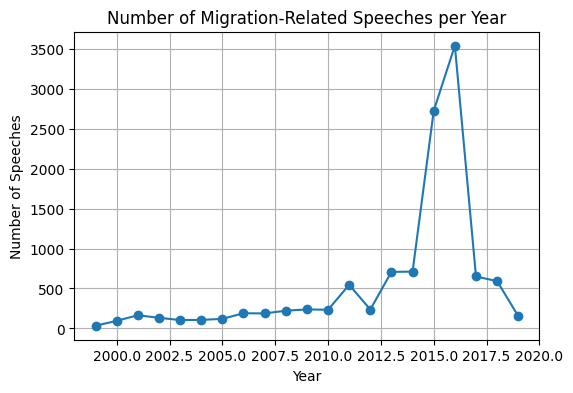

In [104]:
# plot number of migration speeches per year
migration_counts_per_year = df_migration['year'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
plt.plot(migration_counts_per_year.index, migration_counts_per_year.values, marker='o')
plt.title('Number of Migration-Related Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.grid()
plt.show()

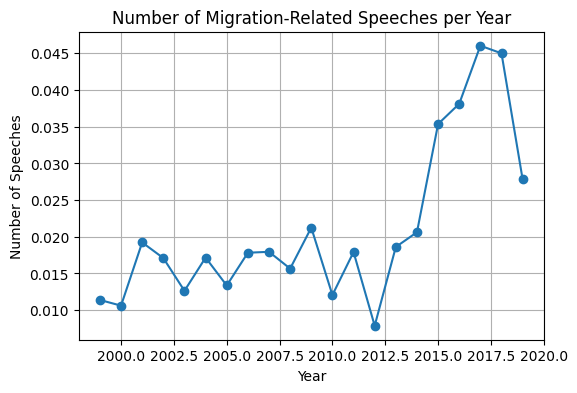

In [ ]:
# normalized plot: ratio of migration speeches to total speeches per year
speech_counts_per_year = df_party_members['year'].value_counts().sort_index()
ratio_per_year = migration_counts_per_year / speech_counts_per_year
plt.figure(figsize=(6, 4))
plt.plot(migration_counts_per_year.index, ratio_per_year, marker='o')
plt.title('Ratio of Migration-Related Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Ratio of Speeches')
plt.grid()
plt.show()

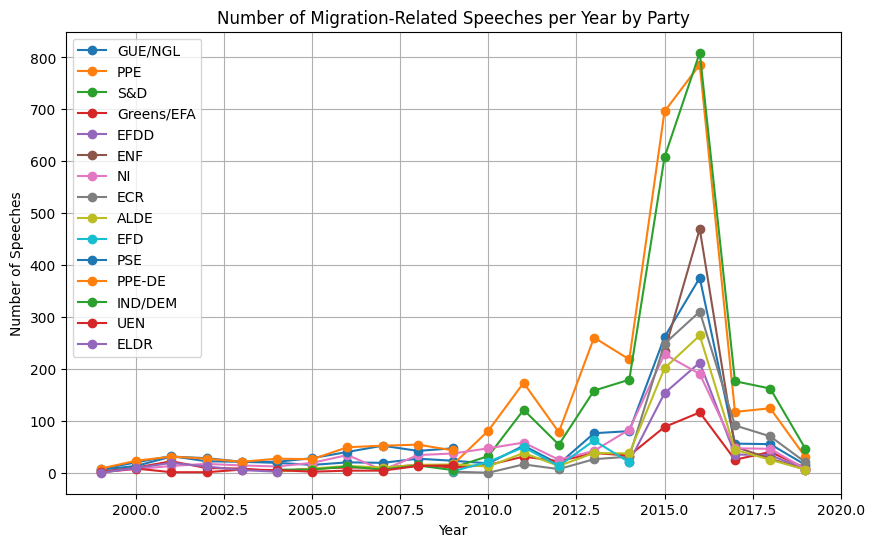

In [106]:
# plot number of migration speeches per year, separated by party
parties = df_migration['party'].unique()

# exclude parties with very few speeches
speech_cutoff = 50
parties = [party for party in parties if df_migration[df_migration['party'] == party].shape[0] >= speech_cutoff]
plt.figure(figsize=(10, 6))
for party in parties:
    party_data = df_migration[df_migration['party'] == party]
    counts_per_year = party_data['year'].value_counts().sort_index()
    plt.plot(counts_per_year.index, counts_per_year.values, marker='o', label=party)
plt.title('Number of Migration-Related Speeches per Year by Party')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend()
plt.grid()
plt.show()

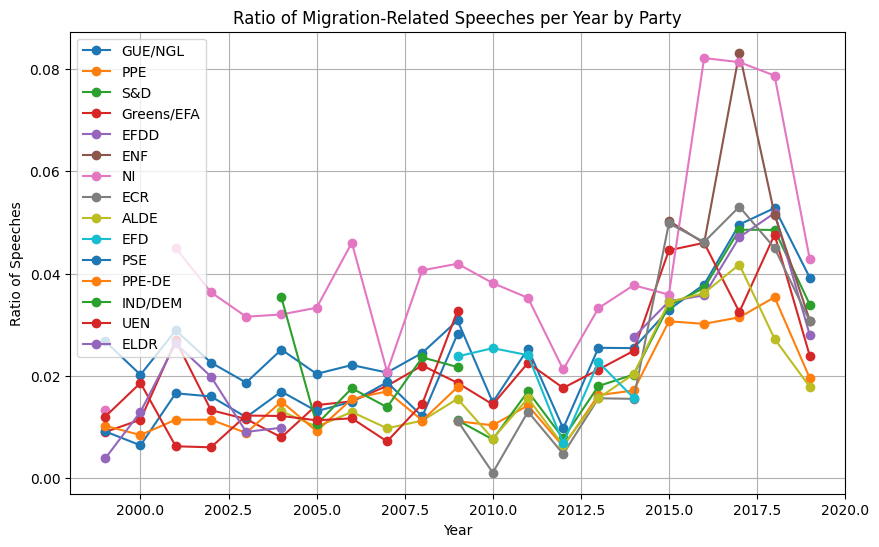

In [107]:
# normalized plot: ratio of migration speeches to total speeches per year, separated by party
plt.figure(figsize=(10, 6))
for party in parties:
    party_data = df_migration[df_migration['party'] == party]
    counts_per_year = party_data['year'].value_counts().sort_index()
    total_counts_per_year = df_party_members[df_party_members['party'] == party]['year'].value_counts().sort_index()
    ratio_per_year = counts_per_year / total_counts_per_year
    plt.plot(ratio_per_year.index, ratio_per_year.values, marker='o', label=party)
plt.title('Ratio of Migration-Related Speeches per Year by Party')
plt.xlabel('Year')
plt.ylabel('Ratio of Speeches')
plt.legend()
plt.grid()
plt.show()

In [108]:
# TODO: look at Topic 68: border, cooperation, crime, state, member
# -> proably more related to europol and international terrorism, smugglery etc.

## Old approach: Use Keyword search to find relevant agendas / speeches

In [109]:
# keywords = ["(M|m)igration", "(M|m)igrant", "(R|r)efugee", "(A|a)sylum", "(T|t)hird(-)?country national"]#, "(F|f)rontex"]
# indices_keyword_identified_speeches = df_party_members.index[df_party_members["uq_agenda"].str.contains("|".join(keywords))].tolist()
# TODO: potentially find relevant keywords using word2vec over text and look for words similar to migration? 

In [110]:
# def filter_for_keywords(df, column="agenda", keywords=keywords, min_contributions_per_agenda_item=10): 
#     relevant_indices = df[column].str.contains("|".join(keywords))
#     agenda_items_vc = df[relevant_indices]["uq_agenda"].value_counts()
    
#     # TODO: do this filtering in the beginning because why not
#     n_agenda_items_before = len(agenda_items_vc)
#     relevant_agendas = agenda_items_vc[agenda_items_vc > min_contributions_per_agenda_item]
#     n_agenda_items_after = len(relevant_agendas)
#     print(f"filtered {n_agenda_items_before-n_agenda_items_after} agenda items with < {min_contributions_per_agenda_item} speeches")
    
#     relevant_indices = relevant_indices & (df["uq_agenda"].isin(relevant_agendas.index))
    
#     print(f"n speeches: {len(df[relevant_indices])}")
#     print(f"n agendas: {n_agenda_items_after}")
    
#     return df[relevant_indices]

In [111]:
# # agenda items per year; speech per year; 
# # party per agenda item
# # contribution per party per year
# # normalize by original 
# df_filtered = filter_for_keywords(df)

In [112]:
# n_per_year_and_party = df_filtered.groupby(["year"]).size()#.unstack()

# ax = n_per_year_and_party.plot(kind="bar", stacked=False, figsize=(40, 5))
# shortened_labels = [l[:50]+"..." if len(l) > 50 else l for l in [lb.get_text() for lb in ax.get_xticklabels()]]
# _ = ax.set_xticklabels(shortened_labels)

In [113]:
# vc = df_filtered["uq_agenda"].value_counts()
# vc

In [114]:
# df_filtered_text = filter_for_keywords("text")

In [115]:
# n = df_filtered_text["uq_agenda"].value_counts()
# print(n.min(), n.mean(), n.max())

# #df_filtered["uq_agenda"]
# print(len(n))
# # agendas that with more than 4 speeches with relevant keywords, that are not in the agendas that were discovered with keywords in title
# new_relevant_agendas = n[(n>4) & (~n.index.isin(df_filtered["uq_agenda"]))]
# new_relevant_agendas[:20]

In [116]:
# def print_agenda(search_term, n_speeches=None): 
#     all_agendas = df[df["uq_agenda"].str.contains(search_term)]["uq_agenda"].unique()
#     for agenda in all_agendas: 
#         speeches = df[df["uq_agenda"] == agenda].sort_values(by="speechnumber", ascending=True)
#         print("Agenda:", (agenda[:30]+"..." if len(agenda) > 30 else agenda))
#         print("Nr of speeches:", len(speeches))
#         print("")
        
#         if n_speeches:
#             speeches = speeches[:n_speeches]
#         for _, r in speeches.iterrows(): 
#             print(f'({r["speechnumber"]}) {r["speaker"]} ({r['party']}): {r['text'] if not r['translatedText'] else r["translatedText"]}')

In [117]:
# print_agenda("6.4. Situation of fundamental rights in the European Union in 2015", 10)
# print_agenda("7.7. The situation of women refugees and asylum seekers in the EU", 10)
# print_agenda("European Border and Coast Guard", 10)

## Model evaluation

In [118]:
# def evaluate_model(lda_model, dictionary, compute_coherence=True): 
#     if compute_coherence: 
#         print("Computing coherence")
#         coherence_model = CoherenceModel(
#             model=lda_model, 
#             texts=preprocessed_data, 
#             dictionary=dictionary, 
#             coherence='c_v'  # most common coherence measure
#         )
#         coherence_score = coherence_model.get_coherence()
#         print("Coherence:", coherence_score)
#     else: 
#         coherence_score = None 
        
#     # compute which topics are related to migration 
#     migration_topic_indices = lda_model.get_term_topics(lda_model.id2word.token2id["migration"], minimum_probability=0)
#     print("Topics related to 'migration':", len(migration_topic_indices))
    
#     # check if any migration-related topic has probability > 0.05 (arbitrary threshold)
#     threshold = 0.05
#     high_topics = [(tid, prob) for tid, prob in migration_topic_indices if prob > threshold]
#     if len(high_topics) > 0:
#         print(f"Topics with probability > {threshold}: {high_topics}")
#     else:
#         print(f"No migration-related topic has probability > {threshold}")

#     # for each speech with migration-keyworded agenda, get most probable topic
#     topic_counts = Counter()
#     topic_probabilities = []
#     missmatches = 0 
#     for idx in indices_keyword_identified_speeches:
#         # if idx >= len(preprocessed_data):
#         #     break
#         bow = dictionary.doc2bow(preprocessed_data[idx])
#         topic_distribution = lda_model.get_document_topics(bow)
#         most_probable_topic = max(topic_distribution, key=lambda x: x[1])
#         topic_counts[most_probable_topic[0]] += 1
#         topic_probabilities.append(most_probable_topic[1])

#         if most_probable_topic[0] not in dict(migration_topic_indices):
#             missmatches += 1 # count how often the most probable topic is not a migration-related topic

#     print("Most common topics for migration-related speeches:", topic_counts.most_common(len(migration_topic_indices)))
#     print("Average probability of most probable topic for migration-related speeches:", sum(topic_probabilities) / len(topic_probabilities))
#     print("missmatches (most probable topic not migration-related):", missmatches, f"{missmatches / len(indices_keyword_identified_speeches):.2%}")

#     return len(high_topics), coherence_score, missmatches

In [119]:
# n_topic_values = [90, 100, 120]
# n_workers = 8

# import os 
# for n_topics in n_topic_values: 
#     os.makedirs(f"lda/{n_topics}_topics", exist_ok=True)
#     out_path = f"lda/{n_topics}_topics/model.model"
#     num_topics = n_topics
#     n_passes = 5
#     workers = n_workers

#     print("Fitting model with", num_topics, "topics and", n_passes, "passes")
#     lda_model = LdaMulticore(corpus = corpus, id2word=dictionary, num_topics = num_topics, passes = n_passes, workers=workers)
#     lda_model.save(out_path)

#     # Evaluate model
#     evaluate_model(lda_model, dictionary)

### Old Function: Count topic assignments

In [120]:
# def count_topic_assignments(corpus_topics, topic_id, prob_threshold=0.0):
#     total = 0
#     most_prob_count = 0
#     at_least_prob_count = 0

#     most_doc_indices = [] 

#     most_probabilities = []
#     at_least_probabilites = []
#     for i, doc_topics in tqdm(enumerate(corpus_topics), desc="Counting topic assignments"):
#         # skip empty entries
#         if not doc_topics:
#             continue
#         total += 1

#         most_topic, most_prob = max(doc_topics, key=lambda x: x[1])
#         if most_topic == topic_id:
#             most_prob_count += 1
#             most_probabilities.append(most_prob)
#             most_doc_indices.append(i)

#         # probability of the target topic (0.0 if absent)
#         prob_map = dict(doc_topics)
#         prob = prob_map.get(topic_id, 0.0)
#         if prob >= prob_threshold:
#             at_least_prob_count += 1
#             at_least_probabilites.append(prob)

#     if total == 0:
#         return ({
#             "total_docs": 0,
#             "most_prob_count": 0,
#             "at_least_prob_count": 0,
#             "most_avg_prob": 0.0, 
#             "at_least_avg_prob": 0.0,
#         }, [], [])

#     return ({
#         "total_docs": total,
#         "most_prob_count": most_prob_count,
#         "at_least_prob_count": at_least_prob_count, 
#         "most_avg_prob": sum(most_probabilities) / most_prob_count,
#         "at_least_avg_prob": sum(at_least_probabilites) / at_least_prob_count,  
#     }, most_doc_indices, most_probabilities)